<a href="https://colab.research.google.com/github/ppunkz/gold-price-forecasting/blob/master/Goldprice_using_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving goldprice.csv to goldprice.csv


In [ ]:
Col = ['Price','Date']
df = pd.read_csv('goldprice.csv', usecols=Col, parse_dates=['Date'])
df = df.sort_values('Date')
df = df.dropna()

In [ ]:
df

,Date,Price
0,2000-08-30,273.899994
1,2000-08-31,278.299988
2,2000-09-01,277.000000
3,2000-09-05,275.799988
4,2000-09-06,274.200012
...,...,...
4952,2020-06-15,1720.300049
4953,2020-06-16,1729.599976
4954,2020-06-17,1729.199951
4955,2020-06-18,1724.800049


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, train_size=.9, shuffle=False)
train.columns = ['ds','y']
test.columns = ['ds','y']
df.columns = ['ds','y']

In [ ]:
print(train.shape)
print(test.shape)
print(df.shape)

(4461, 2)
(496, 2)
(4957, 2)


In [ ]:
test.loc[(test['ds'] >= '2019-01-01') & (test['ds'] <= '2019-12-31')]

,ds,y
4570,2019-01-02,1281.000000
4571,2019-01-03,1291.800049
4572,2019-01-04,1282.699951
4573,2019-01-07,1286.800049
4574,2019-01-08,1283.199951
...,...,...
4814,2019-12-23,1482.500000
4815,2019-12-26,1509.300049
4816,2019-12-27,1513.800049
4817,2019-12-30,1514.500000


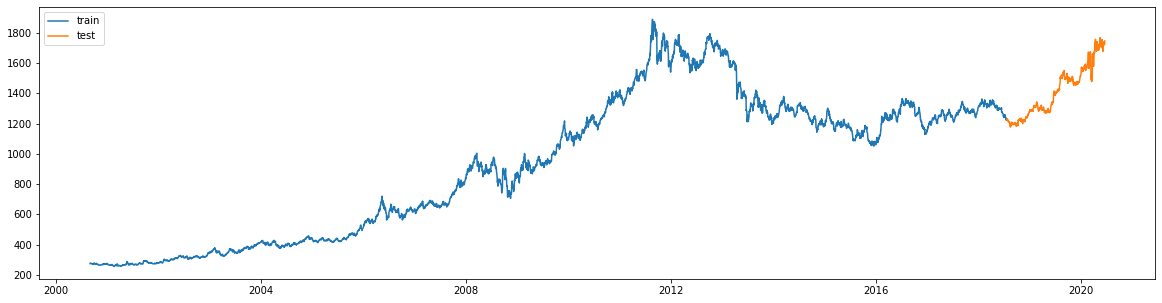

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(train.ds, train.y, label ='train')
plt.plot(test.ds, test.y, label = 'test')
plt.legend()
plt.show()

In [ ]:
#create prophet
prophet = Prophet(growth='linear',
                  seasonality_mode = 'multiplicative',
                  seasonality_prior_scale = 25,
                  daily_seasonality=False,
                  weekly_seasonality=False,
                  yearly_seasonality=False,
                  changepoint_prior_scale=30,
                  n_changepoints = 265,
                  interval_width=0.70
                  ).add_seasonality(name='yearly', period=265, fourier_order=10
                  ).add_seasonality(name='decadely',period=265 * 3, fourier_order=20
                                    ).add_seasonality(name='monthly', period = 24, fourier_order =10
                                                      ).add_seasonality(name='quarterly', period = 24 * 3, fourier_order = 8
                                                                        ).add_seasonality(name='weekly',period=6, fourier_order = 15
                                                                                          ).add_seasonality(name='daily', period=1, fourier_order =10)
                                   
prophet.fit(train)

future = prophet.make_future_dataframe(freq = 'D', periods = 496)

forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,ds,yhat,yhat_lower,yhat_upper
4950,2019-11-25,1375.747459,807.209968,1935.296684
4951,2019-11-26,1375.601945,810.590893,1940.330922
4952,2019-11-27,1370.035664,809.407735,1938.628081
4953,2019-11-28,1362.103084,802.097579,1928.542279
4954,2019-11-29,1366.441587,799.089841,1943.236152
4955,2019-11-30,1363.886932,787.309853,1934.008485
4956,2019-12-01,1360.008639,800.340618,1928.474909


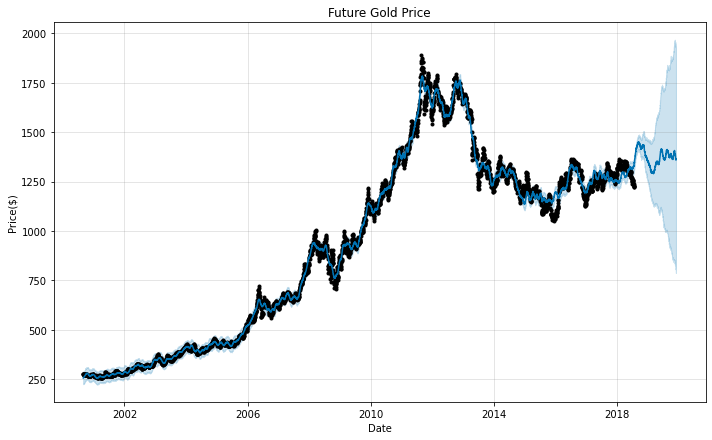

In [ ]:
#plot forecasts
prophet.plot(forecast, xlabel='Date', ylabel='Price($)')
plt.title('Future Gold Price')
# display graph
plt.show()

In [ ]:
test_forecast = prophet.predict(test)
test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
489,2020-06-12,1377.849114,408.749630,2292.817582
490,2020-06-14,1372.447326,409.052712,2268.000573
491,2020-06-15,1376.799638,428.572584,2294.607354
492,2020-06-16,1379.674730,415.497594,2299.230317
493,2020-06-17,1376.035255,415.175347,2313.092118
494,2020-06-18,1376.043218,409.840105,2312.701540
495,2020-06-19,1377.286311,401.293775,2307.633220


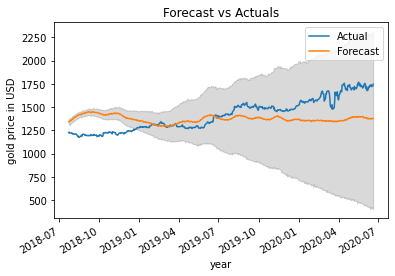

In [ ]:
f, ax = plt.subplots()
#f.set_figheight(5)
#f.set_figwidth(8)
test.plot(kind='line',x='ds', y='y', label='Actual', ax=ax)
test_forecast.plot(kind='line',x='ds',y='yhat',label='Forecast', ax=ax)
plt.fill_between(test_forecast['ds'], test_forecast['yhat_lower'], test_forecast['yhat_upper'], 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.xlabel('year')
plt.ylabel('gold price in USD')
plt.show()

In [ ]:
from math import sqrt
mae = mean_absolute_error(test['y'],test_forecast['yhat'])
rmse = sqrt(mean_squared_error(test['y'], test_forecast['yhat']))
print("MAE",round(mae,4))
print("RMSE", round(rmse,4))

MAE 156.4111
RMSE 187.6114


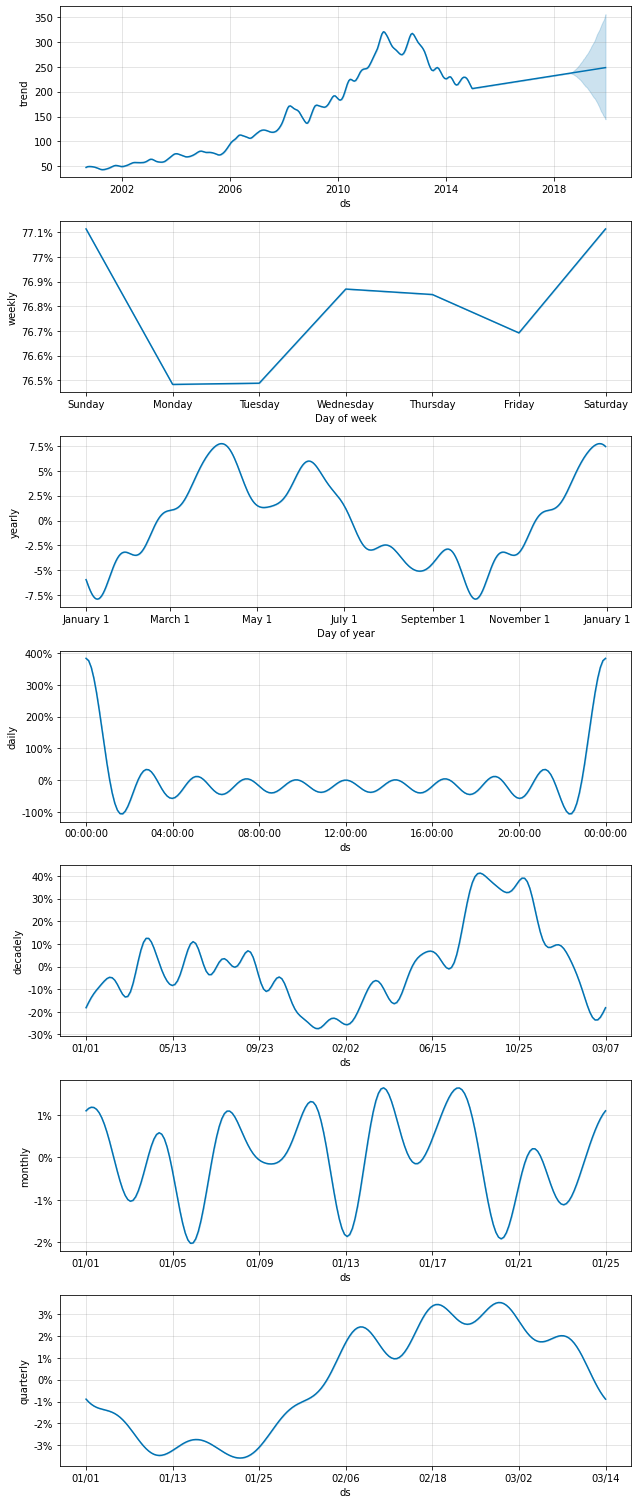

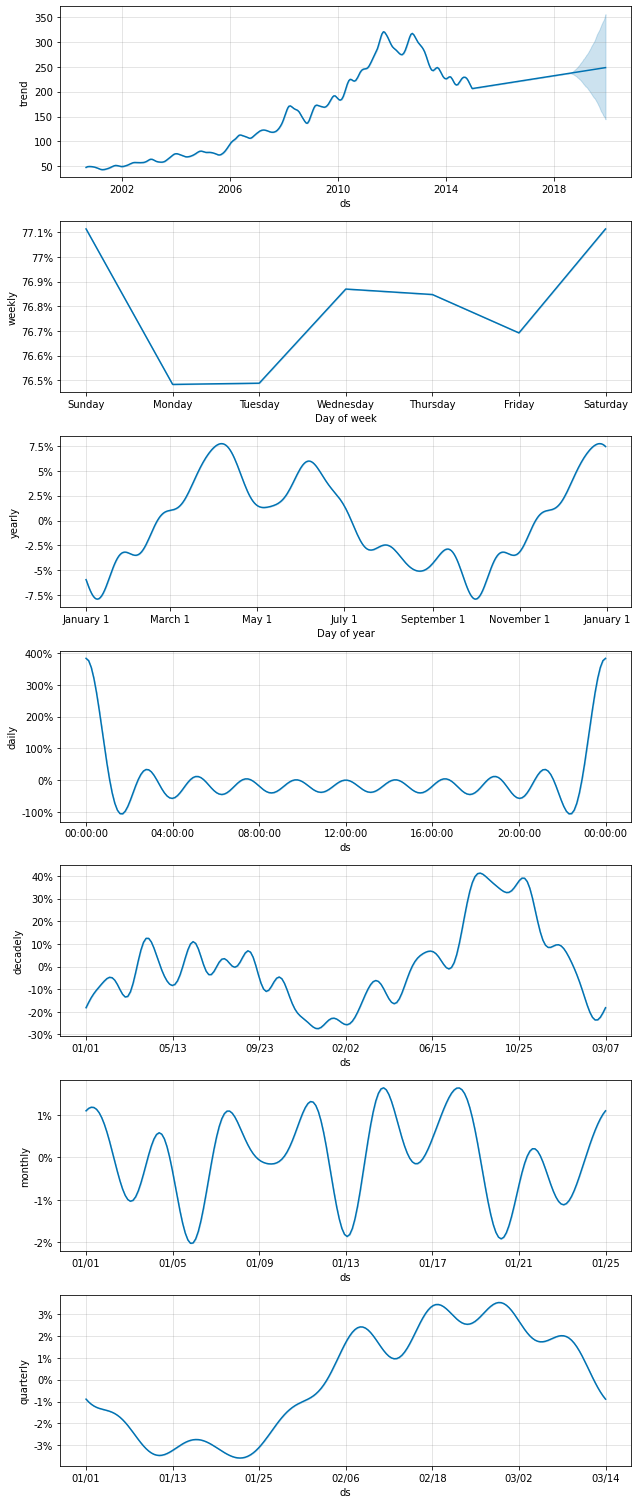

In [ ]:
  prophet.plot_components(forecast)

In [ ]:
cv_result = cross_validation(prophet, initial='700 days', period='133 days', horizon='265 days')
mae = mean_absolute_error(cv_result.y, cv_result.yhat)

INFO:fbprophet:Making 42 forecasts with cutoffs between 2002-11-26 00:00:00 and 2017-10-31 00:00:00
